In [1]:
import numpy as np
import scipy.io as sio
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import linalg as LA

import csv
import os
import json
import math
import time
import pickle
import random

from glob import glob
from collections import defaultdict
from scipy import signal
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
from utilities import *
from utilitiesDL import *
torch.set_num_threads(1)

## Parameter Configuration

In [2]:
jsonFileName = './inputJson/genData_TAR_win.json'

f = open(jsonFileName)
inputJson = json.load(f)
dataPathBase = inputJson['dataPathBase']
dataType = inputJson['dataType']
dSamp = inputJson['dSamp']
padLen = inputJson['padLen']
dataWin = inputJson['dataWin']
surro = inputJson['surro']
attackScheme = 'no'
f.close()

cudaID = 5
if cudaID >= 0:
    device = torch.device("cuda:"+str(cudaID))
    cudaAvbl = True
else:
    device = torch.device("cpu")
    cudaAvbl = False


print("Datatype:", dataType)
if dataType == 'JAR':
    fs = 320
    nSubC = 30
    nRX = 3
    
    dSampFactor = 1
    activities = ['sitstill', 'falldown', 'liedown', 'standstill', 'walk', 'turn', 'stand', 'sit']

elif dataType == 'TAR':
    fs = 500 # 1 kHz
    nSubC = 30
    nRX = 3
    
    activities = ['bed', 'fall', 'run', 'sitdown', 'standup', 'walk']
    # activities = ['fall', 'pickup', 'run', 'sitdown', 'standup', 'walk']

if surro:
    dSampSurro = dSamp
else:
    dSampTarget = dSamp

dataPath = dataPathBase + "HAR_" + dataType + "/"
if dataType == 'JAR':
    dataPath = dataPath + "dSamp_" + str(dSamp) + "/"
elif dataType == 'TAR':
    
    if dataWin:
        variableLen = False
        # padLen = 250
        if attackScheme == "GAIL" or attackScheme == "FGM" or attackScheme == "Univ" or attackScheme == "BC":
            dataPath = dataPath + "win_dSamp_" + str(dSamp) + "_" + attackScheme + "/"
        else:
            dataPath = dataPath + "win_dSamp_" + str(dSamp) + "_pad_" + str(padLen) + "/"
    else:
        variableLen = True
        # padLen = 9
        dataPath = dataPath + "noWin_dSamp_" + str(dSamp) + "_pad_" + str(padLen) + "/"
print('dataPath:', dataPath)


Datatype: TAR
dataPath: /project/iarpa/wifiHAR/HAR_TAR/win_dSamp_2_pad_250/


## Load data

In [3]:
noiseAmpRatio = .5

dataDict = {file:[] for file in activities}
for activity in activities:
    dataDict[activity] = defaultdict(list)

if attackScheme == "GAIL":
    fileName_prefix = "input_TAR_BiLSTM_H_200_dS_10_"
    fileName_prefix_attack = "GAIL_TAR_BiLSTM_H_200_dS_10_"
elif attackScheme == "FGM":
    fileName_prefix = "input_TAR_BiLSTM_H_200_dS_10_"
    fileName_prefix_attack = "FGM_TAR_BiLSTM_H_200_dS_10_"
elif attackScheme == "Univ":
    fileName_prefix = "input_TAR_BiLSTM_H_200_dS_10_"
    fileName_prefix_attack = "Univ_TAR_BiLSTM_H_200_dS_10_"
elif attackScheme == "BC":
    fileName_prefix = "input_TAR_BiLSTM_H_200_dS_10_"
    fileName_prefix_attack = "BC_TAR_BiLSTM_H_200_dS_10_"
else:
    fileName_prefix = "xx_"

lenList = []
if dataType == "JAR":
    for actIdx, activity in enumerate(activities):
        xxLoadNP = np.load(dataPath + "xx_" + activity + ".npy", allow_pickle=True)
        for dataInd, data in enumerate(xxLoadNP):
            dataDict[activity]['input'].append(data)
            dataDict[activity]['label'].append(np.argwhere(np.array(activities) == activity)[0][0])

        print(activity, len(dataDict[activity]['input']))

elif dataType == "TAR":
    for actIdx, activity in enumerate(activities):
        longestLen = 0
        shortestLen = 10000
        # dataDict[activity] = defaultdict(list)
        
        if dataWin:
            xxLoadNP = np.load(dataPath + fileName_prefix + activity + ".npy", allow_pickle=True)
            seqLen = xxLoadNP.shape[1] - padLen
            if attackScheme == "GAIL" or attackScheme == "FGM" or attackScheme == "Univ" or attackScheme == "BC":
                GAILLoadNP = np.load(dataPath + fileName_prefix_attack + activity + ".npy", allow_pickle=True)
        else:
            xxLoadNP = np.load(dataPath + "xx_" + activity + ".npy", allow_pickle=True)
        if attackScheme == "GAIL" or attackScheme == "FGM" or attackScheme == "Univ" or attackScheme == "BC":
            for dataInd, (data, dataGAIL) in enumerate(zip(xxLoadNP, GAILLoadNP)):
                if data.shape[0] > longestLen:
                    longestLen = data.shape[0]
                if data.shape[0] < shortestLen:
                    shortestLen = data.shape[0]
                # print(LA.norm(data), LA.norm(dataGAIL*10))
                dataDict[activity]['input'].append((data + dataGAIL * noiseAmpRatio * 10))
        else:
            for dataInd, data in enumerate(xxLoadNP):
                # print(data.shape)
                if data.shape[0] > longestLen:
                    longestLen = data.shape[0]
                if data.shape[0] < shortestLen:
                    shortestLen = data.shape[0]
                dataDict[activity]['input'].append(data)
        lenList.append(LA.norm(torch.Tensor(data)))
        dataDict[activity]['label'] = actIdx*torch.ones(len(dataDict[activity]['input']), dtype=int, device=device)

        print(activity, len(dataDict[activity]['input']), len(dataDict[activity]['label']), shortestLen, longestLen)

bed 658 658 1250 1250
fall 443 443 1250 1250
run 1209 1209 1250 1250
sitdown 412 412 1250 1250
standup 305 305 1250 1250
walk 1465 1465 1250 1250


## Create train/test torch dataset

In [4]:
if dataWin:
    batchSize = 200
else:
    batchSize = 1
trData = list()
tsData = list()
if attackScheme == "GAIL" or attackScheme == "FGM" or attackScheme == "Univ" or attackScheme == "BC":
    padLen = 0

random.seed(1)
for actIndex, activity in enumerate(activities):
    dataset = CSIDataset(dataDict[activity],\
                        device,\
                        normalize=True,\
                        nSubC=nSubC,\
                        nRX=nRX,\
                        padLen=padLen)
    # nTrData = np.floor(len(dataset)*0.01).astype(int)
    # nTsData = np.floor(len(dataset)).astype(int) - nTrData

    if dataType == "JAR":
        padLen = 0
        if actIndex == 0:
            surroTsList = [512, 1, 2, 514, 4, 6, 7, 8, 519, 520, 523, 524, 13, 525, 15, 527, 17, 18, 530, 20, 21,\
                        22, 533, 534, 535, 538, 28, 541, 30, 31, 32, 33, 547, 36, 37, 38, 39, 40, 548, 42, 549,\
                        551, 553, 554, 47, 48, 49, 556, 51, 52, 53, 559, 562, 56, 57, 563, 564, 60, 61, 62, 63,\
                        567, 65, 570, 67, 68, 69, 575, 71, 72, 583, 584, 75, 585, 77, 588, 79, 80, 81, 82, 83, 589,\
                        85, 86, 590, 88, 592, 594, 91, 92, 93, 94, 95, 96, 99, 100, 102, 107, 109, 111, 112, 113, 116,\
                        118, 124, 126, 128, 130, 133, 135, 137, 138, 140, 141, 146, 147, 150, 153, 154, 155, 156, 161,\
                        163, 166, 167, 172, 173, 177, 178, 181, 182, 186, 187, 188, 190, 198, 199, 202, 203, 207, 208,\
                        211, 212, 213, 214, 218, 220, 221, 223, 225, 226, 229, 230, 234, 235, 238, 239, 240, 241, 247,\
                        252, 254, 255, 256, 257, 258, 259, 261, 262, 267, 270, 273, 274, 276, 277, 278, 279, 281, 282,\
                        285, 287, 289, 291, 292, 293, 296, 297, 299, 301, 302, 303, 304, 309, 571, 315, 317, 572, 321,\
                        322, 331, 336, 337, 339, 341, 344, 345, 347, 348, 350, 351, 353, 355, 356, 358, 360, 363, 369,\
                        371, 373, 374, 375, 376, 377, 378, 379, 381, 388, 392, 394, 395, 398, 403, 404, 406, 407, 409,\
                        410, 411, 412, 414, 415, 591, 420, 421, 422, 423, 424, 426, 427, 431, 434, 435, 436, 437, 438,\
                        439, 440, 441, 447, 449, 451, 453, 454, 455, 599, 458, 459, 460, 461, 462, 463, 464, 465, 466,\
                        467, 470, 471, 472, 473, 474, 475, 477, 478, 479, 481, 482, 485, 487, 488, 490, 491, 494, 496, 500, 501, 502, 503, 504, 505, 506]
            if surro:
                tsDataList = surroTsList
                trDataList = list(set(range(len(dataset))) - set(tsDataList))
            else:
                trDataList = surroTsList
                tsDataList = list(set(range(len(dataset))) - set(trDataList))

    elif dataType == "TAR":
        if dataWin:
            trDataList = random.sample(range(len(dataset)), int(0.5*len(dataset)))
            tsDataList = list(set(range(len(dataset))) - set(trDataList))
        else:
            if actIndex == 0:
                surroTrList = [0, 1, 3, 4, 7, 10, 11, 13, 14, 15, 21, 22, 24, 27, 28, 29, 30, 32, 39, 40,\
                            41, 42, 43, 46, 49, 52, 53, 55, 59, 60, 61, 62, 63, 67, 68, 69, 70, 73, 76, 78]
                if surro:
                    trDataList = surroTrList
                    tsDataList = list(set(range(len(dataset))) - set(trDataList))
                else:
                    tsDataList = surroTrList
                    trDataList = list(set(range(len(dataset))) - set(tsDataList))

    trData.append(torch.utils.data.Subset(dataset, trDataList))
    tsData.append(torch.utils.data.Subset(dataset, tsDataList))
    print(activity, len(trDataList), len(tsDataList), len(dataset))

trDataset = torch.utils.data.ConcatDataset(trData) # concatenating dataset lists
tsDataset = torch.utils.data.ConcatDataset(tsData)

if dataWin:
    trLoader = DataLoader(trDataset, batch_size=batchSize, shuffle=False)
    tsLoader = DataLoader(tsDataset, batch_size=batchSize, shuffle=False)

else:
    trLoader = DataLoader(trDataset, batch_size=batchSize, shuffle=False, collate_fn=collate_fn)
    tsLoader = DataLoader(tsDataset, batch_size=batchSize, shuffle=False, collate_fn=collate_fn)
print("# of tr data:", len(trDataset), "# of ts data:", len(tsDataset))

bed 329 329 658
fall 221 222 443
run 604 605 1209
sitdown 206 206 412
standup 152 153 305
walk 732 733 1465
# of tr data: 2244 # of ts data: 2248


## Test/Confusion matrix

['bed', 'fall', 'run', 'sitdown', 'standup', 'walk']


[Text(0, 0, 'Lie down'),
 Text(0, 1, 'Fall'),
 Text(0, 2, 'Run'),
 Text(0, 3, 'Sit down'),
 Text(0, 4, 'Stand up'),
 Text(0, 5, 'Walk')]

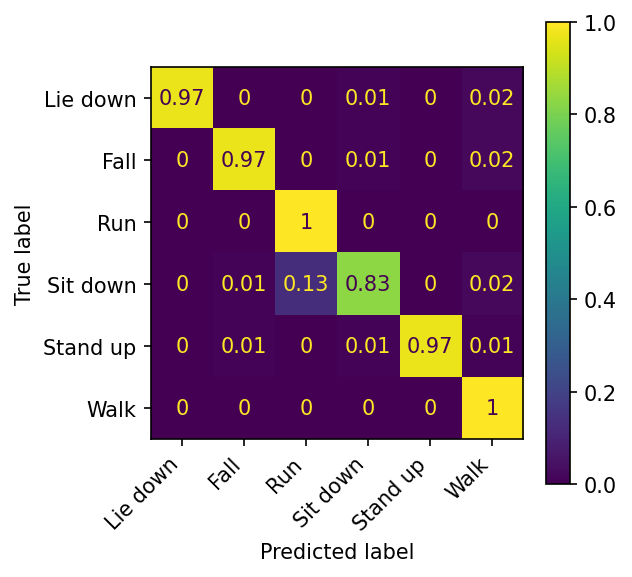

In [6]:
biDir = True
nHidden = 200

if biDir:
    LSTMName = 'BiLSTM'
else:
    LSTMName = 'LSTM'

if surro:
    modelName = dataType + "_" + LSTMName + "_H_" + str(nHidden) + "_dS_" + str(dSamp)
else:
    modelName = dataType + "_target_" + LSTMName + "_H_" + str(nHidden) + "_dS_" + str(dSamp)
    
if dataWin:
    modelName = modelName + "_win"

HARNetSavePath = './savedModels/selected/' + modelName + '.cpkt'
if dataWin:
    HARNet = LSTMNet_TAR(nClasses=len(activities),\
                    input_size=nSubC*nRX,\
                    bidirectional=biDir,\
                    hidden_size=nHidden,\
                    num_layers=1,\
                    seq_length=seqLen,\
                    device=device)
else:
    HARNet = VariableLSTMNet(nClasses=len(activities),\
                    input_size=nSubC*nRX,\
                    bidirectional=biDir,\
                    hidden_size=nHidden,\
                    num_layers=1,\
                    device=device)
HARNet.to(device)
HARNet.load_state_dict(torch.load(HARNetSavePath))


noiseAmpRatio = 1e-6
pred, target = getPreds(tsLoader, HARNet, HARNet, dSamp, dSamp,\
                variableLen, noiseAmpRatio=noiseAmpRatio, noiseType='FGM')
cm = confusion_matrix(target,pred,normalize ='true')
for i in range(len(activities)):
    for j in range(len(activities)):
        cm[i, j] = round(cm[i, j], 2)

print(activities)
if dataType == 'JAR':
    activityLabel = ['Sit still', 'Fall down', 'Lie down', 'Stand still', 'Walk', 'Turn', 'Stand', 'Sit']

elif dataType == 'TAR':
    activityLabel = ['Lie down', 'Fall', 'Run', 'Sit down', 'Stand up', 'Walk']
    # activities = ['fall', 'pickup', 'run', 'sitdown', 'standup', 'walk']

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(4,4), dpi =150)
disp.plot(ax=ax)

ax.set_xticklabels(activityLabel, rotation=45, ha='right')
ax.set_yticklabels(activityLabel)

## Test with white-box/black-box/Universal FGM

In [14]:
# noiseAmpRatioList = [0]
noiseAmpRatioList = [1e-6, 1e-3, 2e-3, 5e-3, 1e-2, 2e-2, 5e-2, 0.1, 0.2, 0.5, 1, 2, 5, 10]

# batchSize = 1
nLayer = 1
dSampTarget = 2
biDirTarget = True
nHiddenTarget = 200
dataWinTarget = True

dSampSurro = 2
biDirSurro = True
nHiddenSurro = 200
dataWinSurro = True

if biDirTarget:
    LSTMNameTarget = "BiLSTM"
else:
    LSTMNameTarget = "LSTM"
if biDirSurro:
    LSTMNameSurro = "BiLSTM"
else:
    LSTMNameSurro = "LSTM"


modelFileNameTarget = dataType + '_target_' + LSTMNameTarget +\
    '_H_' + str(nHiddenTarget) + "_dS_" + str(dSampTarget)
if dataWinTarget:
    modelFileNameTarget = modelFileNameTarget + "_win"

modelFileNameSurro = dataType + '_surro_' + LSTMNameSurro +\
    '_H_' + str(nHiddenTarget) + "_dS_" + str(dSampTarget)
if dataWinSurro:
    modelFileNameSurro = modelFileNameSurro + "_win"

HARNetTargetSavePath = './savedModels/selected/' + modelFileNameTarget + ".cpkt"
HARNetSurroSavePath = './savedModels/selected/' + modelFileNameSurro + ".cpkt"

print('Target:', modelFileNameTarget)
print('Surro:', modelFileNameSurro)

if dataWin:
    HARNetTarget = LSTMNet_TAR(nClasses=len(activities),\
                    input_size=nSubC*nRX,\
                    bidirectional=biDirTarget,\
                    hidden_size=nHiddenTarget,\
                    num_layers=1,\
                    seq_length=seqLen,\
                    device=device)
    HARNetSurro = LSTMNet_TAR(nClasses=len(activities),\
                    input_size=nSubC*nRX,\
                    bidirectional=biDirSurro,\
                    hidden_size=nHiddenSurro,\
                    num_layers=1,\
                    seq_length=seqLen,\
                    device=device)
else:
    HARNetTarget = VariableLSTMNet(nClasses=len(activities),\
                    input_size=nSubC*nRX,\
                    bidirectional=biDirTarget,\
                    hidden_size=nHiddenTarget,\
                    num_layers=1,\
                    device=device)
    HARNetSurro = VariableLSTMNet(nClasses=len(activities),\
                    input_size=nSubC*nRX,\
                    bidirectional=biDirSurro,\
                    hidden_size=nHiddenSurro,\
                    num_layers=1,\
                    device=device)
    
HARNetTarget.load_state_dict(torch.load(HARNetTargetSavePath))
HARNetTarget.to(device)
HARNetTarget.eval()

HARNetSurro.load_state_dict(torch.load(HARNetSurroSavePath))
HARNetSurro.to(device)
HARNetSurro.eval()

for noiseAmpRatio in noiseAmpRatioList: 
    accTest = getAcc(tsLoader,\
                    HARNetTarget,\
                    HARNetTarget,\
                    dSampTarget,\
                    dSampSurro,\
                    variableLen=variableLen,\
                    noiseAmpRatio=noiseAmpRatio,\
                    noiseType='FGM')
    # accTest = getAcc(tsLoader, padLen, HARNet, variableLen=True)
    print('NoiseAmpRatio: {0}, Test Acc.: {1:.1f}%'.format(noiseAmpRatio, 100*accTest))

Target: TAR_target_BiLSTM_H_200_dS_2_win
Surro: TAR_surro_BiLSTM_H_200_dS_2_win


/home/byk004/24-RT_adv_HAR/utilities.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(self.labels[idx], device=self.device).long()
/home/byk004/24-RT_adv_HAR/utilities.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs_padded = pad_sequence([torch.tensor(seq) for seq in inputs],


NoiseAmpRatio: 1e-06, Test Acc.: 97.6%


KeyboardInterrupt: 

## Training from here

In [9]:
LSTMLoss = torch.nn.CrossEntropyLoss()
nHidden = 200
LR = 1e-5
maxPatience = 40
nEpoch = 200
biDir = True
if biDir:
    LSTMName = 'BiLSTM'
else:
    LSTMName = 'LSTM'

dSampFactor = 10
if surro:
    modelName = dataType + "_" + LSTMName + "_H_" + str(nHidden) + "_dS_" + str(dSamp) + '.cpkt'
else:
    modelName = dataType + "_target_" + LSTMName + "_H_" + str(nHidden) + "_dS_" + str(dSamp) + '.cpkt'
if dataWin:
    modelName = modelName + "_win"

HARNetSavePath = './savedModels/selected/' + modelName

print('save model path:', HARNetSavePath)
fromInit = False

if dataWin:
    HARNet = LSTMNet_TAR(nClasses=len(activities),\
                    input_size=nSubC*nRX,\
                    bidirectional=biDir,\
                    hidden_size=nHidden,\
                    num_layers=1,\
                    seq_length=seqLen,\
                    device=device)
else:
    HARNet = VariableLSTMNet(nClasses=len(activities),\
                    input_size=nSubC*nRX,\
                    bidirectional=biDir,\
                    hidden_size=nHidden,\
                    num_layers=1,\
                    device=device)
HARNet.to(device)

if fromInit:
    HARNet.apply(init_weights)
else:
    HARNet.load_state_dict(torch.load(HARNetSavePath))
opt = torch.optim.Adam(HARNet.parameters(), lr=LR)

save model path: ./savedModels/selected/TAR_target_BiLSTM_H_200_dS_10.cpkt


In [11]:
bestAcc = 0.0
patience = 0
fastConvg = True

torch.set_num_threads(1)
print('save model path:', HARNetSavePath)
for epoch in range(nEpoch):
    runningLoss = 0.0
    HARNet.train()      
    for trData in trLoader:
        if dataWin:
            trInput = trData['input']
            trLabel = trData['label']
        else:
            trInput, trLabel = trData

        trLabel = trLabel.to(device)
        # print(trInput.shape)
        opt.zero_grad()
        
        trOutput = HARNet(trInput)
        # print(trOutput.shape)
        trloss = LSTMLoss(trOutput, trLabel)
        trloss.backward()
        opt.step()
        runningLoss += trloss.item()

    avgTrLoss = runningLoss / len(trLoader)
    accTrain = getAcc(trLoader, padLen, HARNet, HARNet, variableLen=True)

    runningLoss = 0.0
    for tsInput, tsLabel in tsLoader:
        tsLabel = tsLabel.to(device)
        opt.zero_grad()
        # tsInput = tsData['input']
        # tsLabel = tsData['label']
        
        tsOutput = HARNet(tsInput)
        tsloss = LSTMLoss(tsOutput, tsLabel)
        runningLoss += tsloss.item()

    avgTsLoss = runningLoss / len(tsLoader)
    accTest = getAcc(tsLoader, padLen, HARNet, HARNet, variableLen=True)

    print('Epoch: %d, trLoss: %.3f, trAcc: %.3f, tsLoss: %.3f, tsAcc: %.3f'\
        % (epoch, avgTrLoss, accTrain, avgTsLoss, accTest), end=' ')
    if bestAcc < accTest:
        bestAcc = accTest
        print('saving model', end=' ')
        torch.save(HARNet.state_dict(), HARNetSavePath)  # saving model with best test accuracy
        patience = 0

    # print(trData.shape, trLabel.shape)
    # early stopping if model converges twice
    patience += 1
    if patience > maxPatience:
        if fastConvg:
            LR = LR/10
            opt = torch.optim.Adam(HARNet.parameters(), lr=LR)
            HARNet.load_state_dict(torch.load(HARNetSavePath))
            patience = 0
            fastConvg = False
            print('fast convergence ends', end=' ')
        else:
            break
    print(' ')
print('Training finished')

save model path: ./savedModels/LSTM/TAR_BiLSTM_H_200_dS_10.cpkt


/home/byk004/24-RT_adv_HAR/utilities.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(self.labels[idx], device=self.device).long()
/home/byk004/24-RT_adv_HAR/utilities.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs_padded = pad_sequence([torch.tensor(seq) for seq in inputs],


Epoch: 0, trLoss: 1.204, trAcc: 0.950, tsLoss: 1.175, tsAcc: 0.927 saving model  
Epoch: 1, trLoss: 1.140, trAcc: 0.971, tsLoss: 1.154, tsAcc: 0.940 saving model  
Epoch: 2, trLoss: 1.140, trAcc: 0.908, tsLoss: 1.235, tsAcc: 0.850  
Epoch: 3, trLoss: 1.210, trAcc: 0.921, tsLoss: 1.250, tsAcc: 0.859  
Epoch: 4, trLoss: 1.234, trAcc: 0.925, tsLoss: 1.249, tsAcc: 0.876  
Epoch: 5, trLoss: 1.189, trAcc: 0.871, tsLoss: 1.270, tsAcc: 0.855  
Epoch: 6, trLoss: 1.233, trAcc: 0.792, tsLoss: 1.277, tsAcc: 0.782  
Epoch: 7, trLoss: 1.262, trAcc: 0.846, tsLoss: 1.250, tsAcc: 0.821  
Epoch: 8, trLoss: 1.217, trAcc: 0.854, tsLoss: 1.227, tsAcc: 0.859  
Epoch: 9, trLoss: 1.198, trAcc: 0.938, tsLoss: 1.240, tsAcc: 0.902  
Epoch: 10, trLoss: 1.191, trAcc: 0.958, tsLoss: 1.199, tsAcc: 0.932  
Epoch: 11, trLoss: 1.164, trAcc: 0.958, tsLoss: 1.179, tsAcc: 0.932  
Epoch: 12, trLoss: 1.139, trAcc: 0.963, tsLoss: 1.173, tsAcc: 0.936  
Epoch: 13, trLoss: 1.128, trAcc: 0.967, tsLoss: 1.187, tsAcc: 0.919  
Epoc

/home/byk004/24-RT_adv_HAR/utilities.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(self.labels[idx], device=self.device).long()
/home/byk004/24-RT_adv_HAR/utilities.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs_padded = pad_sequence([torch.tensor(seq) for seq in inputs],


['bed', 'fall', 'run', 'sitdown', 'standup', 'walk']


[Text(0, 0, 'Lie down'),
 Text(0, 1, 'Fall'),
 Text(0, 2, 'Run'),
 Text(0, 3, 'Sit down'),
 Text(0, 4, 'Stand up'),
 Text(0, 5, 'Walk')]

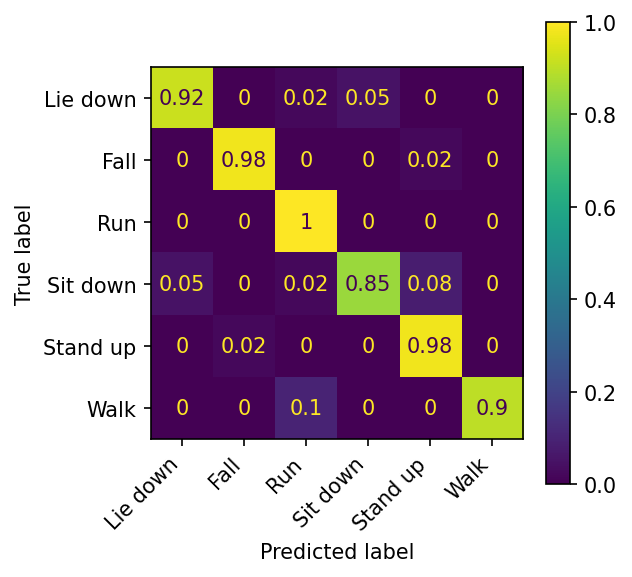

In [10]:
noiseAmpRatio = 0.0
variableLen = True
pred, target = getPreds(tsLoader, padLen, HARNet, HARNet,\
                variableLen, noiseAmpRatio=noiseAmpRatio, noiseType='FGM')
cm = confusion_matrix(target,pred,normalize ='true')
for i in range(len(activities)):
    for j in range(len(activities)):
        cm[i, j] = round(cm[i, j], 2)

# print(pred)
# print(target)
print(activities)
if dataType == 'JAR':
    activityLabel = ['Sit still', 'Fall down', 'Lie down', 'Stand still', 'Walk', 'Turn', 'Stand', 'Sit']

elif dataType == 'TAR':
    activityLabel = ['Lie down', 'Fall', 'Run', 'Sit down', 'Stand up', 'Walk']
    # activities = ['fall', 'pickup', 'run', 'sitdown', 'standup', 'walk']


disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(4,4), dpi =150)
disp.plot(ax=ax)

ax.set_xticklabels(activityLabel, rotation=45, ha='right')
ax.set_yticklabels(activityLabel)

In [16]:
def getPreds_dSamp(loader, loaderPadLen, modelTarget, modelSurrogate, dSamp, variableLen=False, noiseAmpRatio = 0.0, noiseType = 'random', print_time = False):
    # get predictions from network
    device = modelTarget.device
    modelTarget.eval()
    pred_l   = []
    label_l = [] 
    
    if noiseType == 'FGM':
        modelSurrogate.train()

    start = time.time()
    for batch in loader:
        if variableLen:
            batchInput, batchLabel = batch
        else:
            batchInput = batch['input']
            batchLabel = batch['label']
        
        batchLabel = batchLabel.to(device)
           
        # if loaderPadLen > 0:
        #     batchInput = batchInput[:, loaderPadLen:, :]
        # inputFlatten = batchInput.view(batchInput.shape[0], -1)
        batchInput = batchInput[:,::dSamp,:]
        # print(batchInput.shape)
        inputFlatten = torch.reshape(batchInput, (batchInput.shape[0], -1))
        inputFlatten = inputFlatten * torch.numel(inputFlatten) /\
            (LA.norm(inputFlatten) * nSubC * nRX)

        noiseAmp = LA.norm(inputFlatten, dim=1) * noiseAmpRatio
        if noiseType == 'random':
            noise = torch.randn(inputFlatten.shape, device=device)
        elif noiseType == 'FGM':
            batchInput.requires_grad = True
            modelSurrogate.zero_grad()
            loss = nn.CrossEntropyLoss()
            loss = loss(modelSurrogate(batchInput), batchLabel)
            loss.backward()
            noise = (batchInput.grad.data).view(batchInput.shape[0], -1)
        noise = torch.mul(torch.div(noise, LA.norm(noise, dim=1).unsqueeze(1)),\
                            noiseAmp.unsqueeze(1))

        # print(LA.norm(inputFlatten), LA.norm(noise))
        inputNoiseFlatten = inputFlatten + noise
        batchInput = inputNoiseFlatten.view(batchInput.shape)
        # print(LA.norm(batchInput).item(), LA.norm(noise).item())

        outputs = modelTarget(batchInput)

        pred_l.extend(outputs.detach().max(dim=1).indices.cpu().tolist())
        label_l.extend(batchLabel.cpu().tolist())
        
    if print_time:
        end = time.time()
        print('time per example:', (end-start)/len(label_l))

    return pred_l, label_l

In [18]:
noiseAmpRatio = 0.0
variableLen = True
pred, target = getPreds_dSamp(tsLoader, padLen, HARNet, HARNet, 5,\
                variableLen, noiseAmpRatio=noiseAmpRatio, noiseType='FGM')
cm = confusion_matrix(target,pred,normalize ='true')
for i in range(len(activities)):
    for j in range(len(activities)):
        cm[i, j] = round(cm[i, j], 2)

# print(pred)
# print(target)
print(activities)
if dataType == 'JAR':
    activityLabel = ['Sit still', 'Fall down', 'Lie down', 'Stand still', 'Walk', 'Turn', 'Stand', 'Sit']

elif dataType == 'TAR':
    activityLabel = ['Lie down', 'Fall', 'Run', 'Sit down', 'Stand up', 'Walk']
    # activities = ['fall', 'pickup', 'run', 'sitdown', 'standup', 'walk']


disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(4,4), dpi =150)
disp.plot(ax=ax)

ax.set_xticklabels(activityLabel, rotation=45, ha='right')
ax.set_yticklabels(activityLabel)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (200x80000 and 400000x6)

In [6]:
def getAcc(loader, loaderPadLen, modelTarget, modelSurrogate, variableLen=False, noiseAmpRatio = 0.0, noiseType = 'random'):
    '''
    get accuracy from predictions
    '''
    pred_l,label_l = getPreds(loader,loaderPadLen,\
                            modelTarget,\
                            modelSurrogate,\
                            variableLen,\
                            noiseAmpRatio=noiseAmpRatio,\
                            noiseType=noiseType)
    
    # print(pred_l)
    correct = 0.
    for pred, label in zip(pred_l,label_l):
        correct += (pred==label)

    print(correct)
    return correct/len(pred_l)

In [15]:
# noiseAmpRatioList = [0]
noiseAmpRatioList = [0, 1e-3, 2e-3, 5e-3, 1e-2, 2e-2, 5e-2, 0.1, 0.2, 0.5, 1, 2, 5, 10]

batchSize = 1
nLayer = 1

biDirTarget = True
nHiddenTarget = 200

biDirSurro = True
nHiddenSurrogate = 200

if biDirTarget:
    modelTargetName = "BiLSTM"
else:
    modelTargetName = "LSTM"
if biDirSurro:
    modelSurroName = "BiLSTM"
else:
    modelSurroName = "LSTM"

# HARNetPath = './savedModels/LSTM/' + modelFileName
HARNetPath = './savedModels/selected/' + modelFileName

# if dataWin:
#     HARNet = LSTMNet_TAR(nClasses=len(activities),\
#                     input_size=nSubC*nRX,\
#                     bidirectional=bidirectional,\
#                     hidden_size=nHidden,\
#                     num_layers=1,\
#                     seq_length=1000,\
#                     device=device)
# else:
#     HARNet = VariableLSTMNet(nClasses=len(activities),\
#                     input_size=nSubC*nRX,\
#                     bidirectional=bidirectional,\
#                     hidden_size=nHidden,\
#                     num_layers=1,\
#                     device=device)
# HARNet.to(device)
# HARNet.load_state_dict(torch.load(HARNetPath))

HARNetTargetSavePath = './savedModels/LSTM/' + dataType + '_target_' + modelTargetName +\
    '_H_' + str(nHiddenTarget) + "_dS_" + str(dSampFactor) + ".cpkt"
HARNetSurroSavePath = './savedModels/LSTM/' + dataType + '_' + modelSurroName +\
    '_H_' + str(nHiddenSurrogate) + "_dS_" + str(dSampFactor) + ".cpkt"

HARNetTargetSavePath = './savedModels/LSTM/' + dataType + '_target_' + modelTargetName +\
    '_H_' + str(nHiddenTarget) + "_win.cpkt"
HARNetSurroSavePath = './savedModels/LSTM/' + dataType + '_surro_' + modelSurroName +\
    '_H_' + str(nHiddenSurrogate) + "_win.cpkt"

if dataWin:
    HARNetTarget = LSTMNet_TAR(nClasses=len(activities),\
                    input_size=nSubC*nRX,\
                    bidirectional=biDirTarget,\
                    hidden_size=nHiddenTarget,\
                    num_layers=1,\
                    seq_length=seqLen,\
                    device=device)

    HARNetSurro = LSTMNet_TAR(nClasses=len(activities),\
                    input_size=nSubC*nRX,\
                    bidirectional=biDirSurro,\
                    hidden_size=nHiddenSurrogate,\
                    num_layers=1,\
                    seq_length=seqLen,\
                    device=device)

else:
    HARNetTarget = VariableLSTMNet(nClasses=len(activities),\
                    input_size=nSubC*nRX,\
                    bidirectional=biDirTarget,\
                    hidden_size=nHiddenTarget,\
                    num_layers=1,\
                    device=device)

    HARNetSurro = VariableLSTMNet(nClasses=len(activities),\
                    input_size=nSubC*nRX,\
                    bidirectional=biDirSurro,\
                    hidden_size=nHiddenSurrogate,\
                    num_layers=1,\
                    device=device)
    
HARNetTarget.load_state_dict(torch.load(HARNetTargetSavePath))
HARNetTarget.to(device)
HARNetTarget.eval()

HARNetSurro.load_state_dict(torch.load(HARNetSurroSavePath))
HARNetSurro.to(device)
HARNetSurro.eval()

loaderPadLen = padLen
for noiseAmpRatio in noiseAmpRatioList:
    accTest = getAcc(tsLoader,\
                    padLen,\
                    HARNetTarget,\
                    HARNetSurro,\
                    variableLen=True,\
                    noiseAmpRatio=noiseAmpRatio,\
                    noiseType='FGM')
    # accTest = getAcc(tsLoader, padLen, HARNet, variableLen=True)
    print('NoiseAmpRatio: {0}, Test Acc.: {1:.1f}%'.format(noiseAmpRatio, 100*accTest))

/home/byk004/24-RT_adv_HAR/utilities.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(self.labels[idx], device=self.device).long()
/home/byk004/24-RT_adv_HAR/utilities.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs_padded = pad_sequence([torch.tensor(seq) for seq in inputs],


NoiseAmpRatio: 0, Test Acc.: 97.6%
NoiseAmpRatio: 0.001, Test Acc.: 97.6%
NoiseAmpRatio: 0.002, Test Acc.: 97.6%
NoiseAmpRatio: 0.005, Test Acc.: 97.6%
NoiseAmpRatio: 0.01, Test Acc.: 97.3%
NoiseAmpRatio: 0.02, Test Acc.: 94.8%
NoiseAmpRatio: 0.05, Test Acc.: 72.3%
NoiseAmpRatio: 0.1, Test Acc.: 38.1%
NoiseAmpRatio: 0.2, Test Acc.: 13.7%
NoiseAmpRatio: 0.5, Test Acc.: 4.3%
NoiseAmpRatio: 1, Test Acc.: 3.6%
NoiseAmpRatio: 2, Test Acc.: 5.5%
NoiseAmpRatio: 5, Test Acc.: 6.5%
NoiseAmpRatio: 10, Test Acc.: 7.3%


## Save CSI data and FGM noise

In [10]:
nData = 0
batchSize = 1
padLen = 25

dSampFactor = 2
surro_dSamp = 10
dSamp_ratio = int(surro_dSamp / dSampFactor)

bidirectional = True
nHidden = 200

if bidirectional:
    modelName = "BiLSTM"
else:
    modelName = "LSTM"
modelFileName = 'TAR_' + modelName + '_H_' + str(nHidden) + '_dS_' + str(surro_dSamp)
HARNetPath = './savedModels/LSTM/' + modelFileName + '.cpkt'
print('Model to compute FGM:', HARNetSavePath)
HARNet = VariableLSTMNet(nClasses=len(activities),\
                input_size=nSubC*nRX,\
                bidirectional=bidirectional,\
                hidden_size=nHidden,\
                num_layers=1,\
                device=device)
HARNet.to(device)
HARNet.load_state_dict(torch.load(HARNetPath))
model = HARNet

for actInd, activity in enumerate(activities):
    inputList = []
    FGMList = []
    labelList = []

    print('activity:', activity, end=' ')
    datasetAct = CSIDataset(dataDict[activity], device)
    loader = DataLoader(datasetAct, batch_size=batchSize, shuffle=False)
    noiseAmpRatio = .1

    device = model.device
    model.to(device)
    model.train()
    # loss = loss(model())

    dataInput_fileName = "/project/iarpa/wifiHAR/HAR_TAR/noWin_dSamp_" +\
        str(dSampFactor)+ "_pad_" + str(padLen) + "_FGM/input_" + modelFileName + "_" + activity
    dataFGM_fileName = "/project/iarpa/wifiHAR/HAR_TAR/noWin_dSamp_" +\
        str(dSampFactor)+ "_pad_" + str(padLen) + "_FGM/FGM_" + modelFileName + "_" + activity
    
    for batch in loader:
        batchInput = batch['input']
        batchInput = batchInput * torch.numel(batchInput) /\
            (LA.norm(batchInput) * nSubC * nRX)
        batchInputWoPad = batchInput[:, padLen:, :]
        # print(batchInputWoPad.shape)
        batchInputWoPad = batchInputWoPad[:,::dSamp_ratio,:]
        batchInputWoPad = batchInputWoPad * torch.numel(batchInputWoPad) /\
            (LA.norm(batchInputWoPad) * nSubC * nRX)

        inputFlatten = batchInputWoPad.view(batchInputWoPad.shape[0], -1)
        noiseAmp = LA.norm(inputFlatten, dim=1) * noiseAmpRatio
        batchLabel = batch['label']
        
        batchInputWoPad.requires_grad = True
        model.zero_grad()
        loss = nn.CrossEntropyLoss()
        lossOutput = loss(model(batchInputWoPad), batchLabel)
        lossOutput.backward()
        noise = (batchInputWoPad.grad.data).view(batchInputWoPad.shape[0], -1)
        noiseNorm = torch.mul(torch.div(noise, LA.norm(noise, dim=1).unsqueeze(1)),\
                              noiseAmp.unsqueeze(1))

        # print(LA.norm(batchInput).item(), LA.norm(noiseNorm).item())
        inputList.append(torch.squeeze(batchInput).cpu().detach())
        batchNoiseNorm = noiseNorm.view(batchInputWoPad.shape)
        # print(batchInput.shape, batchNoiseNorm.shape)

        FGMList.append(torch.squeeze(batchNoiseNorm).cpu().detach())
        labelList.append([actInd])

    # np.save(dataInput_fileName, np.array(inputList, dtype=object), allow_pickle=True)
    # np.save(dataFGM_fileName, np.array(FGMList, dtype=object), allow_pickle=True)
    print('nDataAct:', len(inputList))
print('nData:', nData)

Model to compute FGM: ./savedModels/selected/TAR_target_BiLSTM_H_200_win.cpkt
activity: bed nDataAct: 658
activity: fall 

KeyboardInterrupt: 

## Load saved pre-trained LSTM model and evaluate (noise may be added)

In [40]:
noiseAmpRatioList = [1e-2]
# noiseAmpRatioList = [1e-5, 1e-4, 5e-4, 1e-3, 2e-3, 5e-3, 1e-2, 2e-2, 5e-2, 7.5e-2, 0.1, 0.2, 0.5]

nHidden = 200
thres = 60
batchSize = 200
nLayer = 1
bidirectional = True
if bidirectional:
    modelName = "BLSTM"
else:
    modelName = "LSTM"
HARNetSavePath = './savedModels/selected/TAR_BiLSTM_H_200.cpkt'

HARNet = VariableLSTMNet(nClasses=len(activities),\
                input_size=nSubC*nRX,\
                bidirectional=bidirectional,\
                hidden_size=nHidden,\
                num_layers=1,\
                device=device)
HARNet.load_state_dict(torch.load(HARNetSavePath))
HARNet.to(device)

loaderPadLen = padLen
for noiseAmpRatio in noiseAmpRatioList:
    correct = 0.0
    # accTest = getAcc(trLoader, 9, HARNet, variableLen=True,\
    #                  noiseAmpRatio=noiseAmpRatio, noiseType='FGM')
    print(len(inputList), len(FGMList), len(labelList))
    # for trInput, trFGM, trLabel in zip(inputList, FGMList, labelList):
    #     print(trInput.shape)
    pred_l, label_l = getPredsGAIL(inputList, FGMList, torch.Tensor(labelList), HARNet,\
                        noiseAmpRatio=noiseAmpRatio, padLen=padLen)    
    for pred, label in zip(pred_l, label_l):
        print(pred, label.item())
        nData += 1
        correct += (pred == label)

    print('NoiseAmpRatio:', noiseAmpRatio, ' Test accuracy:', correct/len(inputList))

477 477 477
3 tensor([0.])
0 tensor([0.])
0 tensor([0.])
0 tensor([0.])
0 tensor([0.])
3 tensor([0.])
0 tensor([0.])
3 tensor([0.])
3 tensor([0.])
3 tensor([0.])
0 tensor([0.])
0 tensor([0.])
0 tensor([0.])
0 tensor([0.])
0 tensor([0.])
2 tensor([0.])
5 tensor([0.])
0 tensor([0.])
0 tensor([0.])
0 tensor([0.])
0 tensor([0.])
0 tensor([0.])
0 tensor([0.])
1 tensor([0.])
2 tensor([0.])
3 tensor([0.])
2 tensor([0.])
0 tensor([0.])
0 tensor([0.])
0 tensor([0.])
0 tensor([0.])
0 tensor([0.])
0 tensor([0.])
2 tensor([0.])
0 tensor([0.])
0 tensor([0.])
3 tensor([0.])
0 tensor([0.])
0 tensor([0.])
0 tensor([0.])
0 tensor([0.])
3 tensor([0.])
0 tensor([0.])
0 tensor([0.])
0 tensor([0.])
0 tensor([0.])
0 tensor([0.])
0 tensor([0.])
0 tensor([0.])
3 tensor([0.])
4 tensor([0.])
0 tensor([0.])
0 tensor([0.])
0 tensor([0.])
5 tensor([0.])
0 tensor([0.])
2 tensor([0.])
0 tensor([0.])
0 tensor([0.])
0 tensor([0.])
0 tensor([0.])
0 tensor([0.])
0 tensor([0.])
0 tensor([0.])
0 tensor([0.])
0 tensor([0.]

In [ ]:
nDataTs = 0
for tsBatch in tsLoader:
    nDataTs += tsBatch['obs'].shape[0]

lineBreakCount = 0
for noiseAmpRatio in noiseAmpRatioList:
    correct = 0.
    for trAgentBatch in tsLoader:
        trObsBatchwoPad = trAgentBatch['obs'][:, padLen:, :]
        pred_l,label_l = getPredsGAIL(trObsBatchwoPad, trAgentBatch['FGM'], trAgentBatch['label'],\
                                        HARNet, noiseAmpRatio)
        for pred, label in zip(pred_l, label_l):
            correct += (pred == label)
    print('[{0}, {1:.3f}]'.format(noiseAmpRatio, correct/nDataTs), end=' ')

    lineBreakCount += 1
    if lineBreakCount == 4:
        print('')
        lineBreakCount = 0


In [ ]:
nData = 0
batchSize = 1
for actInd, activity in enumerate(activities):
    datasetAct = CSIDataset(dataDict[activity], device)
    loader = DataLoader(datasetAct, batch_size=batchSize, shuffle=False)

    for batch in loader:
        nData += batch['input'].shape[0]
print('nData:', nData, end=' ')


correct = 0.
for actInd, activity in enumerate(activities):
    datasetAct = CSIDataset(dataDict[activity], device)

    model = HARNet
    loader = DataLoader(datasetAct, batch_size=batchSize, shuffle=False)
    noiseAmpRatio = .1

    device = model.device
    model.to(device)
    model.train()

    dataInputPaddedAct = torch.empty((0, ((winLen//2+padLen) * nSubC*nRX))).to(device)
    dataNoiseAct = torch.empty((0, ((winLen//2) * nSubC*nRX))).to(device)
    dataInput_fileName = "/project/iarpa/wifiHAR/HAR_TAR/noWin_FGM_pad_" +\
        str(padLen) + "/input_" + dataType + "_LSTM_H_200_th_" + str(thres) + "_L_1_" + activity + ".npy"
    dataNoise_fileName = "/project/iarpa/wifiHAR/HAR_TAR/noWin_FGM_pad_" +\
        str(padLen) + "/noise_" + dataType + "_LSTM_H_200_th_" + str(thres) + "_L_1_" + activity + ".npy"

    for batch in loader:
        model.zero_grad()
        model.train()
        inputFlatten = batch['input'].view(batch['input'].shape[0], -1)
        noiseAmp = LA.norm(inputFlatten, dim=1) * (winLen//2) / (winLen//2 + padLen) * noiseAmpRatio

        batcchInputWoPad = batch['input'][:, padLen:, :]
        batcchInputWoPad.requires_grad = True
        loss = nn.CrossEntropyLoss()
        loss = loss(model(batcchInputWoPad), batch['label'])
        loss.backward()
        batchNoise = (batcchInputWoPad.grad.data).view(batcchInputWoPad.shape[0], -1)
        batchNoise = torch.mul(torch.div(batchNoise, LA.norm(batchNoise, dim=1).unsqueeze(1)),\
                            noiseAmp.unsqueeze(1))
        batchInput = batch['input'].view(batch['input'].shape[0], -1)

        batchLabel =\
            actInd * torch.ones_like(torch.empty(batchInput.shape[0], device=device), dtype=int)

        pred_l,label_l = getPredsGAIL(batcchInputWoPad, batchNoise, batchLabel,\
                                HARNet, noiseAmpRatio)
        for pred, label in zip(pred_l, label_l):
            correct += (pred == label)


        # print(batchInput.shape, batchNoise.shape, batcchInputWoPad.shape)
        dataInputPaddedAct = torch.cat((dataInputPaddedAct, batchInput), 0)
        dataNoiseAct = torch.cat((dataNoiseAct, batchNoise), 0)
        # print(dataInputPaddedAct.shape, dataNoiseAct.shape)

    dataInputPaddedActNp = dataInputPaddedAct.cpu().detach().numpy()
    dataNoiseActNp = dataNoiseAct.cpu().detach().numpy()
    print('activity:', activity, dataInputPaddedActNp.shape, dataNoiseActNp.shape)
    with open(dataInput_fileName, 'wb') as f:
        np.save(f, dataInputPaddedActNp)
    with open(dataNoise_fileName, 'wb') as f:
        np.save(f, dataNoiseActNp)

print('[{0}, {1:.3f}]'.format(noiseAmpRatio, correct/nData))


## save non-windowed data (but dowmsanpled)

In [ ]:
padLen = 9
print(dataPath)
noWindDataPath = dataPath + "noWin_pad" + str(padLen) + "/"
for activity in activities:
    if dataType == "TAR":
        fileNameList = glob(dataPath + "/input_" + activity + "*.csv")
        outputXXFileName = noWindDataPath + "xx_" + activity

        print(activity, len(fileNameList))

        # xx = np.empty([0, (winLen//dSampFactor + padSize), nSubC*nRX], float)
    dataList = []

    for fileIndex, fileName in enumerate(fileNameList):
        data = np.array([[float(elm) for elm in v] for v in csv.reader(open(fileName, 'r'))])
        annotFileName = fileName.replace('input', 'annotation')
        annot = np.array([[str(elm) for elm in v] for v in csv.reader(open(annotFileName, 'r'))])
        annotDownSamp = annot[::dSampFactor]

        indActs = np.where(annot[:, 0] == activity)[0]
        indPad = np.arange(indActs[0]-padLen*dSampFactor, indActs[0], dSampFactor)
        indActswithPad = np.concatenate((indPad, indActs))
        # print(indActswithPad.shape)
        # print(indPad, indActs[:5], indActswithPad[:15])
        
        dataActs = data[indActswithPad, 1:1+nSubC*nRX]
        dataList.append(dataActs)

    np.save(outputXXFileName, np.array(dataList, dtype=object), allow_pickle=True)
    # with open(outputXXFileName, "w+") as f:
    #     pickle.dump(dataList, f)

In [12]:
dataDict = {file:[] for file in activities}
for activity in activities:
    dataDict[activity] = defaultdict(list)

lenList = []
if dataType == "JAR":
    for actIdx, activity in enumerate(activities):
        xxLoadNP = np.load(dataPath + "xx_" + activity + ".npy", allow_pickle=True)
        for dataInd, data in enumerate(xxLoadNP):
            dataDict[activity]['input'].append(data)
            dataDict[activity]['label'].append(np.argwhere(np.array(activities) == activity)[0][0])

        print(activity, len(dataDict[activity]['input']))

elif dataType == "TAR":
    for actIdx, activity in enumerate(activities):
        longestLen = 0
        shortestLen = 10000
        # dataDict[activity] = defaultdict(list)
        
        if dataWin:
            xxLoadNP = np.load(dataPath + "xx_1000_60_" + activity + ".npy", allow_pickle=True)
            print(xxLoadNP.shape)
        else:
            xxLoadNP = np.load(dataPath + "xx_" + activity + ".npy", allow_pickle=True)
        for dataInd, data in enumerate(xxLoadNP):
            if data.shape[0] > longestLen:
                longestLen = data.shape[0]
            if data.shape[0] < shortestLen:
                shortestLen = data.shape[0]
            dataDict[activity]['input'].append(data)
            lenList.append(LA.norm(torch.Tensor(data)))
            
            dataDict[activity]['label'] = actIdx*torch.ones(len(dataDict[activity]['input']), dtype=int, device=device)
        print(activity, len(dataDict[activity]['input']), len(dataDict[activity]['label']), shortestLen, longestLen)

bed 79 79 981 2431
fall 79 79 806 1671
run 80 80 1671 5676
sitdown 80 80 646 1741
standup 79 79 551 1636
walk 80 80 2741 5026
